## Install and Load Necessary Libraries

In [1]:
!pip install tensorflow[and-cuda]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.8/417.8 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.9/13.9 MB 35.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.4/23.4 MB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 845.8/845.8 kB 37.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 720.1/720.1 MB 978.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.9/124.9 MB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.3/195.3 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.2/20.2 MB 16.4 MB/s eta 0:00:00
  Preparing metadata 

In [5]:
# Standard library imports
from typing import OrderedDict
import warnings

# Third-party library imports
import numpy as np
import tensorflow as tf
import cv2
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from skimage import color
from PIL import Image
import requests


In [ ]:
## Load and Download Model

In [3]:
!gdown 1hMc2x7mWAudzQBGgCAH2HOiftdbiUZLD

Downloading...
From (original): https://drive.google.com/uc?id=1hMc2x7mWAudzQBGgCAH2HOiftdbiUZLD
From (redirected): https://drive.google.com/uc?id=1hMc2x7mWAudzQBGgCAH2HOiftdbiUZLD&confirm=t&uuid=ce7fc2ba-7dd6-4b21-bb64-271cbfa3556b
To: /content/UNet-ResNet34.keras
100% 294M/294M [00:07<00:00, 40.0MB/s]


In [6]:
model = tf.keras.models.load_model("./UNet-ResNet34.keras")

## Make Prediction (Face Segmentation Mask)

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


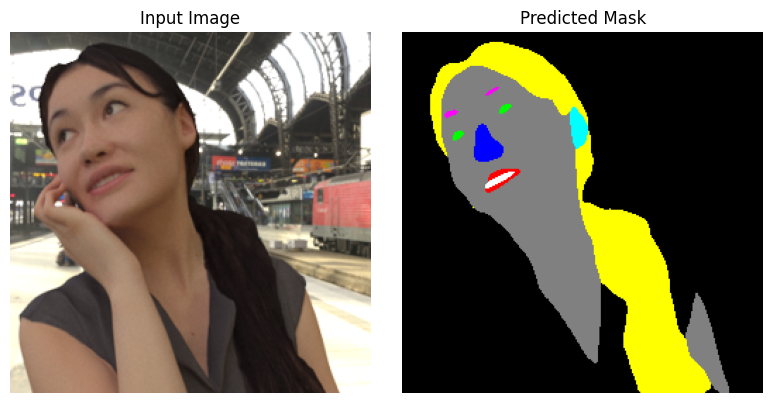

In [8]:
image_url = "./fig1.png"

# Crete the segmentation labels
segmentation_labels = OrderedDict({
    'background': [0, 0, 0],
    'lips': [255, 0, 0],
    'eyes': [0, 255, 0],
    'nose': [0, 0, 255],
    'skin': [128, 128, 128],
    'hair': [255, 255, 0],
    'eyebrows': [255, 0, 255],
    'ears': [0, 255, 255],
    'teeth': [255, 255, 255],
    'beard': [255, 192, 192],
    'sunglasses': [0, 128, 128],
})

labels = list(segmentation_labels.keys())
rgb_values = list(segmentation_labels.values())


# Load and preprocess the user-provided image
img = Image.open(image_url).convert('RGB')
img = img.resize((256, 256))  # Resize the image to match the model's expected input shape
img_array = np.array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Make predictions
pred_mask = model.predict(img_array)[0]
pred_mask = np.argmax(pred_mask, axis=-1)

# Map the predicted mask to RGB colors
pred_rgb = np.zeros((256, 256, 3), dtype=np.uint8)
for i, rgb in enumerate(rgb_values):
    pred_rgb[pred_mask == i] = rgb

# Plot the input image and predicted mask
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(img)
axs[0].set_title('Input Image')
axs[0].axis('off')
axs[1].imshow(pred_rgb)
axs[1].set_title('Predicted Mask')
axs[1].axis('off')
plt.tight_layout()
plt.show()

In [9]:
# Function to convert image tensor from HWD (Height-Width-Depth) to DHW (Depth-Height-Width) convention
def from_HWD_to_DHW(img_HWD):
    return tf.transpose(img_HWD, perm=[2, 0, 1])

# Function to convert image tensor from DHW (Depth-Height-Width) to HWD (Height-Width-Depth) convention
def from_DHW_to_HWD(img_DHW):
    return tf.transpose(img_DHW, perm=[1, 2, 0])


def color_distance(color1_RGB, color2_RGB):
    assert(color1_RGB.shape == (3, 1, 1) and color2_RGB.shape == (3, 1, 1))


    color1_RGB_np_HWD = from_DHW_to_HWD(tf.cast(color1_RGB, tf.float32)).numpy()
    color2_RGB_np_HWD = from_DHW_to_HWD(tf.cast(color2_RGB, tf.float32)).numpy()
    color1_CIELab = color.rgb2lab(color1_RGB_np_HWD)
    color2_CIELab = color.rgb2lab(color2_RGB_np_HWD)
    return np.linalg.norm(color1_CIELab - color2_CIELab)


## Pallete Classification, Based on User's Skin Tone

In [10]:
def from_key_to_index(dictionary, key):
    """
    .. description::
    Returns the index of a certain key in a dictionary.
    """
    return list(dictionary.keys()).index(key)

labels = OrderedDict({ label: segmentation_labels[label] for label in ['skin', 'hair', 'lips', 'eyes'] })

skin_idx = from_key_to_index(labels, 'skin')
hair_idx = from_key_to_index(labels, 'hair')
lips_idx = from_key_to_index(labels, 'lips')
eyes_idx = from_key_to_index(labels, 'eyes')

In [11]:
def color_mask(img, color_triplet=[0, 0, 0]):
    assert(img.shape[0] == 3 and len(color_triplet) == 3)

    ch0, ch1, ch2 = color_triplet
    mask = tf.cast(img[0] == ch0, tf.float32) * tf.cast(img[1] == ch1, tf.float32) * tf.cast(img[2] == ch2, tf.float32)
    return tf.cast(mask, tf.bool)

def compute_segmentation_masks(img_segmented, labels):
    n_labels = len(labels)
    _, H, W = tf.shape(img_segmented)
    masks = tf.zeros((n_labels, H, W), dtype=tf.bool)

    for idx, label in enumerate(labels):
        label_color = labels[label]
        mask = color_mask(img_segmented, label_color)
        masks = tf.tensor_scatter_nd_update(masks, [[idx]], tf.expand_dims(mask, axis=0))

    return masks

def apply_masks(img, masks):
    assert img.shape[1] == masks.shape[1] and img.shape[2] == masks.shape[2], \
        f"Image and mask dimensions do not match. Image shape: {img.shape}, Mask shape: {masks.shape}"

    img = tf.cast(img, tf.float32)


    img_expanded = tf.expand_dims(img, axis=0)
    masks_expanded = tf.expand_dims(tf.cast(masks, tf.float32), axis=1)

    masked_img = img_expanded * masks_expanded
    masked_img = tf.cast(masked_img, tf.uint8)

    return masked_img

In [12]:
img = from_HWD_to_DHW(tf.convert_to_tensor(img))
img_segmented = from_HWD_to_DHW(tf.convert_to_tensor(pred_rgb))

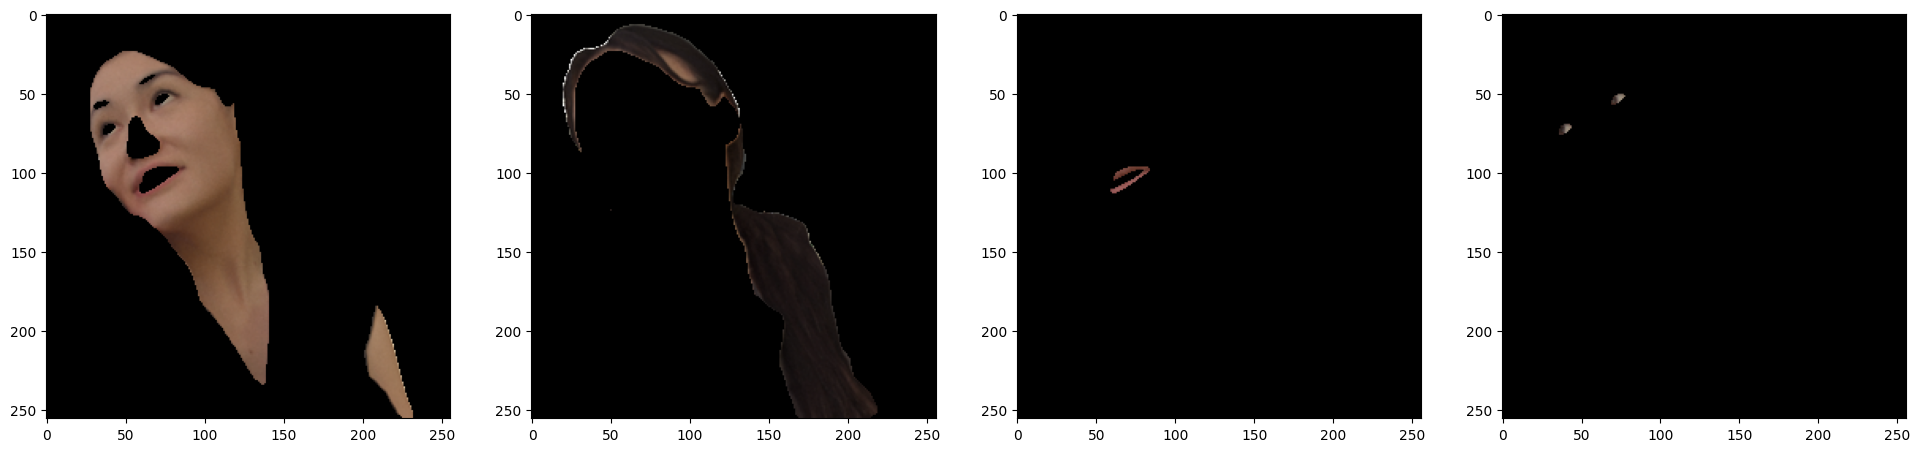

In [13]:
segmentation_masks = compute_segmentation_masks(img_segmented, labels)
img_masked = apply_masks(img, segmentation_masks)
plt.figure(figsize=(24, 14))
plt.subplot(1, 4, 1)
plt.imshow(from_DHW_to_HWD(img_masked[0]))
plt.subplot(1, 4, 2)
plt.imshow(from_DHW_to_HWD(img_masked[1]))
plt.subplot(1, 4, 3)
plt.imshow(from_DHW_to_HWD(img_masked[2]))
plt.subplot(1, 4, 4)
plt.imshow(from_DHW_to_HWD(img_masked[3]))
plt.show()

## Seasonal Color Analysis

In [ ]:
reference_palettes = [PaletteRGB.loadData(name) for name in palettes_data.keys()]

for reference_palette in reference_palettes:
    print(reference_palette.description())
    reference_palette.plot(tile_size=15)


In [17]:
# Define the Color for Seasonal Theory
palettes_data = {
    'autumn': {
        'metrics': '1000',
        'colors': [
            [53, 66, 48],   # KombuGreen
            [134, 126, 54], # OldMossGreen
            [65, 74, 76],   # OuterSpace
            [102, 93, 30],  # BrownishBlack
            [176, 133, 84]  # MetallicBronze
        ]
    },
    'spring': {
        'metrics': '1111',
        'colors': [
            [116, 90, 169],  # BluePurple
            [0, 183, 235],   # CyanBlue
            [0, 255, 0],     # Green
            [255, 68, 51],   # CrayolaOrangeRed
            [255, 112, 54]   # PrincetonOrange
        ]
    },
    'summer': {
        'metrics': '0010',
        'colors': [
            [172, 230, 251],  # CrystalLightBlue
            [140, 146, 172],  # CoolGrey
            [41, 171, 135],   # JungleGreen
            [203, 65, 84],    # BrickRed
            [255, 138, 171]   # MetallicPink
        ]
    },
    'winter': {
        'metrics': '0101',
        'colors': [
            [255, 247, 0],   # LemonYellow
            [27, 24, 17],    # BlackChocolate
            [255, 250, 240], # FloralWhite
            [140, 0, 0],     # DarkCrimson
            [10, 105, 79]    # MetallicGreen
        ]
    }
}


# Create Class for the Seasonal Theory Analysis
class PaletteRGB:
    def __init__(self, description='palette', colors=tf.zeros((1, 3, 1, 1), dtype=tf.uint8)):
        assert isinstance(colors, tf.Tensor)

        self.description_ = str(description)
        self.colors_ = tf.reshape(colors, (3, -1, 1))
        self.metrics_vector_ = None

    @classmethod
    def loadData(cls, name):
        """
        Load palette data from the palettes_data dictionary.

        Args:
            name (str): Name of the palette in the palettes_data dictionary.

        Returns:
            palette: Instance of the PaletteRGB class.
        """
        if name not in palettes_data:
            raise ValueError(f"Palette '{name}' not found in palettes_data.")

        palette_data = palettes_data[name]
        palette = cls(name)

        colors = np.array(palette_data['colors'])
        palette.colors_ = tf.convert_to_tensor(colors.reshape((1, -1, 3)))
        palette.colors_ = from_HWD_to_DHW(palette.colors_)

        if 'metrics' in palette_data:
            header_data = list(palette_data['metrics'].strip())
            palette.metrics_vector_ = tf.convert_to_tensor(np.array(header_data, dtype=np.uint8))

        return palette

    def description(self):
        return self.description_

    def colors(self):
        """
        .. description::
        Returns palette colors, represented by a tensorflow tensor of shape (3, 1, n_colors).
        """
        return self.colors_

    def n_colors(self):
        return self.colors_.shape[2]

    def has_metrics_vector(self):
        return self.metrics_vector_ is not None

    def metrics_vector(self):
        """
        .. description::
        Returns None if the palette has no metrics vector.
        """
        if self.has_metrics_vector():
            return self.metrics_vector_

        return None

    def compute_metrics_vector(self, subtone, intensity, value, contrast, thresholds=(0.5, 0.5, 0.5)):
        """
        .. description::
        Computes the metrics vector of the palette, represented by a binary tensorflow tensor obtained by
        binarizing a specific combination of metrics values. Each metric value (except for the subtone)
        is converted to 1 if above the corresponding threshold or 0 if at or below said
        threshold. Returns False if contrast is None, to indicate that the last element of the metrics vector
        must be ignored, True otherwise.

        .. inputs::
        thresholds:     tuple of thresholds given by (contrast_thresh, intensity_thresh, value_thresh).
        """
        sequence = np.zeros(4, dtype=np.uint8)
        contrast_thresh, intensity_thresh, value_thresh = thresholds

        sequence[0] = 1 if subtone == 'warm' else 0
        sequence[1] = 1 if intensity > intensity_thresh else 0
        sequence[2] = 1 if value > value_thresh else 0
        sequence[3] = 1 if contrast is not None and contrast > contrast_thresh else 0

        self.metrics_vector_ = tf.constant(sequence)

        if contrast is None:
            return False

        return True

    def save(self, filepath='', delimiter=';'):
        """
        .. inputs::
        filepath:   directory in which to save the palette.
        """
        header = ''
        filename = filepath + self.description_ + '.csv'

        if self.has_metrics_vector():
            header = header + '# metrics vector (SIVC)\n' + compact_string_(self.metrics_vector_) + '\n'

        header = header + '# color data\n'
        np.savetxt(filename, from_DHW_to_HWD(self.colors_).numpy().reshape((-1, 3)),
                   header=header, fmt='%u', delimiter=delimiter)

    def load(self, filename, header=False, delimiter=';'):
        """
        .. description::
        header: if True, an header with format:
        >> # metrics vector (SIVC)
        >> XXXX
        >> color data
        with XXXX being the compact string representation of the palette's metrics vector, is present at the beginning
        of the file.
        """
        self.description_ = (str(filename).split('/')[-1]).split('.')[0]

        if header is True:
            file = open(filename)
            file.readline()
            header_data = list(file.readline())
            del header_data[4:]
            self.metrics_vector_ = tf.constant(np.array(header_data, dtype=np.uint8))
            file.close()

        self.colors_ = tf.constant(np.loadtxt(fname=filename, dtype=np.uint8, skiprows=int(header) * 3,
                                               delimiter=delimiter).reshape((1, -1, 3)))
        self.colors_ = from_HWD_to_DHW(self.colors_)
        return self

    def plot(self, tile_size=5):
        """
        .. inputs::
        tile_size:  size of each color tile (in inches).
        """
        plt.figure(figsize=(tile_size, tile_size * self.n_colors()))
        plt.xticks([])
        plt.yticks([])
        plt.imshow(from_DHW_to_HWD(self.colors_).numpy())
        plt.show()

    def distance_from(self, other_palette, type='avg'):
        """
        .. description::
        Method computing a distance measure between calling palette and other_palette. Because the
        two palettes could have a different number of colors, the method first matches each color
        of the calling palette with one color in other_palette (the one having closest hue), and then
        computes a distance between colors for each match. From the resulting vector of distances, a
        single distance value is returned by applying a function between min(), max(), average().

        .. inputs::
        type:   type of function to apply in order to get a single distance value;
                must be in ['min', 'max', 'avg'].
        """
        assert type in ['min', 'max', 'avg']

        distances = []

        for color_idx in range(self.n_colors()):
            min_hue_distance = -1
            closest_color = None
            color = tf.expand_dims(self.colors_[:, :, color_idx], axis=1)
            color_np_HWD = from_DHW_to_HWD(color).numpy()
            color_hue = cv2.cvtColor((color_np_HWD / 255).astype(np.float32), cv2.COLOR_RGB2HSV)[0, 0, 0]

            for other_color_idx in range(other_palette.n_colors()):
                other_color = tf.expand_dims(other_palette.colors()[:, :, other_color_idx], axis=1)
                other_color_np_HWD = from_DHW_to_HWD(other_color).numpy()
                other_color_hue = cv2.cvtColor(
                    (other_color_np_HWD / 255).astype(np.float32), cv2.COLOR_RGB2HSV)[0, 0, 0]
                hue_distance = 180 - abs(abs(color_hue - other_color_hue) - 180)

                if min_hue_distance == -1 or hue_distance < min_hue_distance:
                    min_hue_distance = hue_distance
                    closest_color = other_color

            min_color_distance = color_distance(color, closest_color)
            distances.append(min_color_distance)

        distances = tf.constant(distances)

        if type == 'min':
            distance = distances.min()
        elif type == 'max':
            distance = distances.max()
        elif type == 'avg':
            distance = distances.mean()

        return distance.numpy()

In [22]:
def compute_candidate_dominants_and_reconstructions_(img_masked, n_candidates, return_recs=True):
    _, H, W = img_masked.shape
    kmeans = KMeans(n_clusters=n_candidates, n_init=10, random_state=99)
    mask_i = np.logical_not(color_mask(img_masked))
    img_masked_i_flattened = tf.reshape(from_DHW_to_HWD(img_masked), (H * W, -1)).numpy() / 255

    # Silencing kmeans convergence warnings
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message='Number of distinct clusters*')
        kmeans.fit(img_masked_i_flattened)

    candidates = tf.round(tf.convert_to_tensor(kmeans.cluster_centers_) * 255)

    if return_recs is True:
        reconstructions = []
        for candidate in candidates:
            candidate = tf.reshape(candidate, (3, 1, 1))
            reconstruction = mask_i * candidate
            reconstructions.append(reconstruction)
        reconstructions = tf.stack(reconstructions)
        return candidates, reconstructions

    return candidates, None

def compute_user_embedding(img_masked, n_candidates, distance_fn, debug=False, eyes_idx=3):
    assert img_masked.shape[:2] == (4, 3) and len(n_candidates) == 4

    _, _, H, W = img_masked.shape
    dominants = []

    for i in range(4):
        max_brightness_i = cv2.cvtColor(from_DHW_to_HWD(
            img_masked[i] / 255).numpy().astype(np.float32), cv2.COLOR_RGB2HSV)[:, :, 2].max()
        candidates, reconstructions = compute_candidate_dominants_and_reconstructions_(
            img_masked[i], n_candidates[i])

        min_reconstruction_error = -1
        dominant = tf.zeros((3,), dtype=tf.uint8)

        for j, reconstruction_j in enumerate(reconstructions):
            if tf.reduce_sum(candidates[j]) < 20 or tf.reduce_sum(candidates[j]) > 700:
                continue

            average_brightness_j = cv2.cvtColor(from_DHW_to_HWD(
                reconstruction_j / 255).numpy().astype(np.float32), cv2.COLOR_RGB2HSV)[:, :, 2].mean()
            reconstruction_error_j = distance_fn(img_masked[i], reconstruction_j).numpy()

            if i == eyes_idx:
                # Decrease RMSE of darker colors when computing eyes dominant
                reconstruction_error_j *= (average_brightness_j / max_brightness_i)
            else:
                # Decrease RMSE of brighter colors when computing other dominants
                reconstruction_error_j /= (average_brightness_j / max_brightness_i)

            # Debug
            if debug:
                r, g, b = candidates[j].numpy()
                print(f'Candidate: ({r},{g},{b}), Weighted Reconstruction Error: {reconstruction_error_j}')
                plt.figure(figsize=(20, 10))
                plt.subplot(1, 2, 1)
                plt.imshow(from_DHW_to_HWD(reconstruction_j).numpy())
                plt.subplot(1, 2, 2)
                plt.imshow(from_DHW_to_HWD(img_masked[i]).numpy())
                plt.show()

            if min_reconstruction_error == -1 or reconstruction_error_j < min_reconstruction_error:
                min_reconstruction_error = reconstruction_error_j
                dominant = candidates[j]

        dominants.append(dominant.numpy().tolist())

    return tf.reshape(tf.cast(tf.convert_to_tensor([list(map(lambda x: int(round(x)), d)) for d in dominants]), tf.uint8), (4, 3, 1, 1))

def rmse(img1, img2):
    """
    .. description::
    Converts two images (tf.Tensor instances) of shape (D, H, W) in CIELab and then computes the RMSE between them.
    """
    assert img1.shape == img2.shape

    _, H, W = img1.shape
    img1_np_HWD = from_DHW_to_HWD(tf.cast(img1, tf.float32)).numpy()
    img2_np_HWD = from_DHW_to_HWD(tf.cast(img2, tf.float32)).numpy()
    img1_CIELab = cv2.cvtColor(img1_np_HWD, cv2.COLOR_RGB2Lab)
    img2_CIELab = cv2.cvtColor(img2_np_HWD, cv2.COLOR_RGB2Lab)

    return tf.sqrt(tf.reduce_mean(tf.square(img1_CIELab - img2_CIELab)))

def compact_string_(array):
    """
    .. description::
    Returns a compact string representation of an array by constructing the sequence of its elements.
    e.g. The array [1,1,0,1] results in string '1101'.
    """
    string = ''

    for element in array:
        string += (str(element))

    return string

def compute_subtone(lips_color):
    """
    Computes subtone (S) by comparing lips color with colors peach and purple according to the following rule:
    if lips_color is closest to peach_color then subtone is 'warm'
    else if lips_color is closest to purple_color then subtone is 'cold'

    lips_color: TensorFlow tensor of shape (3, 1, 1).
    """
    assert lips_color.shape == (3, 1, 1), f"Expected shape (3, 1, 1) but got {lips_color.shape}"

    peach_color = tf.constant([255, 230, 182], dtype=tf.uint8)
    purple_color = tf.constant([210, 120, 180], dtype=tf.uint8)

    # Ensure peach_color and purple_color have the same shape as lips_color
    peach_color = tf.reshape(peach_color, lips_color.shape)
    purple_color = tf.reshape(purple_color, lips_color.shape)

    dist_to_peach = color_distance(lips_color, peach_color)
    dist_to_purple = color_distance(lips_color, purple_color)

    if dist_to_peach < dist_to_purple:
        return 'warm'
    else:
        return 'cold'


def compute_contrast(hair_color, eyes_color):
    """
    .. description::
    Computes contrast (C), defined as the brightness difference between hair and eyes. Returns None if
    hair_color is None (meaning that it's unavailable).

    .. inputs::
    hair_color, eyes_color: TensorFlow tensors of shape (3, 1, 1).
    """
    if hair_color is None:
        return None

    hair_color_np_HWD = from_DHW_to_HWD(hair_color).numpy()
    eyes_color_np_HWD = from_DHW_to_HWD(eyes_color).numpy()
    hair_color_HSV = cv2.cvtColor((hair_color_np_HWD / 255).astype(np.float32), cv2.COLOR_RGB2HSV)
    eyes_color_HSV = cv2.cvtColor((eyes_color_np_HWD / 255).astype(np.float32), cv2.COLOR_RGB2HSV)

    return abs(hair_color_HSV[0, 0, 2] - eyes_color_HSV[0, 0, 2])

def compute_intensity(skin_color):
    """
    .. description::
    Computes intensity (I), defined as skin color saturation.

    .. inputs::
    skin_color: TensorFlow tensor of shape (3, 1, 1).
    """
    skin_color_np_HWD = from_DHW_to_HWD(skin_color).numpy()
    skin_color_HSV = cv2.cvtColor((skin_color_np_HWD / 255).astype(np.float32), cv2.COLOR_RGB2HSV)
    return skin_color_HSV[0, 0, 1]

def compute_value(skin_color, hair_color, eyes_color):
    """
    .. description::
    Computes value (V), defined as the overall brightness of skin, hair and eyes. If hair_color is None,
    then the value is computed using only skin_color and eyes_color.

    .. inputs::
    skin_color, hair_color, eyes_color: TensorFlow tensors of shape (3, 1, 1).
    """
    skin_color_np_HWD = from_DHW_to_HWD(skin_color).numpy()
    eyes_color_np_HWD = from_DHW_to_HWD(eyes_color).numpy()
    skin_color_HSV = cv2.cvtColor((skin_color_np_HWD / 255).astype(np.float32), cv2.COLOR_RGB2HSV)
    eyes_color_HSV = cv2.cvtColor((eyes_color_np_HWD / 255).astype(np.float32), cv2.COLOR_RGB2HSV)

    if hair_color is None:
        return (skin_color_HSV[0, 0, 2] + eyes_color_HSV[0, 0, 2]) / 2

    hair_color_np_HWD = from_DHW_to_HWD(hair_color).numpy()
    hair_color_HSV = cv2.cvtColor((hair_color_np_HWD / 255).astype(np.float32), cv2.COLOR_RGB2HSV)

    return (skin_color_HSV[0, 0, 2] + hair_color_HSV[0, 0, 2] + eyes_color_HSV[0, 0, 2]) / 3

def classify_user_palette(user_palette, reference_palettes, with_contrast=True):
    assert user_palette.has_metrics_vector()

    min_hamming_distance = -1
    season = None
    metrics_vector = user_palette.metrics_vector()

    if with_contrast is False:
        metrics_vector = metrics_vector[:-1]

    for reference_palette in reference_palettes:
        assert reference_palette.has_metrics_vector()

        reference_metrics_vector = reference_palette.metrics_vector()

        if with_contrast is False:
            reference_metrics_vector = reference_metrics_vector[:-1]

        if reference_metrics_vector[0] != metrics_vector[0]:
            continue

        hamming_distance = tf.reduce_sum(tf.cast(metrics_vector != reference_metrics_vector, dtype=tf.int32))

        if min_hamming_distance == -1 or hamming_distance < min_hamming_distance:
            min_hamming_distance = hamming_distance
            season = reference_palette

    return season

In [21]:
dominants = compute_user_embedding(img_masked, n_candidates=(3, 3, 3, 3), distance_fn=rmse, debug=False)
dominants_palette = PaletteRGB('dominants', dominants)

In [23]:
# computing color harmony metrics and metrics_vector (see class palette.PaletteRGB)
thresholds = (0.200, 0.422, 0.390)
subtone = compute_subtone(dominants[lips_idx])
intensity = compute_intensity(dominants[skin_idx])
value = compute_value(dominants[skin_idx], dominants[hair_idx], dominants[eyes_idx])
contrast = compute_contrast(dominants[hair_idx], dominants[eyes_idx])
dominants_palette.compute_metrics_vector(subtone, intensity, value, contrast, thresholds)
print(f'metrics_vector: {dominants_palette.metrics_vector()}')

metrics_vector: [0 0 1 1]


In [24]:
season_palette = classify_user_palette(dominants_palette, reference_palettes)
print(f'Season: {season_palette.description()}')
print(f'Subtone: {subtone} \nIntensity: {intensity} \nValue: {value} \nContrast: {contrast}')

Season: summer
Subtone: cold 
Intensity: 0.40397343039512634 
Value: 0.41960787773132324 
Contrast: 0.41568630933761597
